In [1]:
import os
import time
import numpy as np
from keras import backend as K
import tensorflow as tf
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.preprocessing import image
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(50)
from fit_on_batches import *

Using CNTK backend


In [2]:
imgPath = 'DATA/Stored/train/'
maskPath = 'DATA/Stored/train_masks/'
#DIM = (1280, 1920, 3)
DIM = (160, 240, 3)
print('Total {} samples'.format(len([i for i in os.listdir(imgPath)])))

Total 10176 samples


In [3]:
# Define IoU metric and loss
from keras.losses import binary_crossentropy

def dice_coef(y_true, y_pred, smooth=1.):
    y_true_f = K.batch_flatten(y_true)
    y_pred_f = K.batch_flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

def dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [4]:
# Build U-Net model
def conv_block(m, dim, acti, bn, res, do=0):
    n = Conv2D(dim, 3, activation=acti, padding='same')(m)
    n = BatchNormalization()(n) if bn else n
    n = Dropout(do)(n) if do else n
    n = Conv2D(dim, 3, activation=acti, padding='same')(n)
    n = BatchNormalization()(n) if bn else n
    return Concatenate()([m, n]) if res else n

def level_block(m, dim, depth, inc, acti, do, bn, mp, up, res):
    if depth > 0:
        n = conv_block(m, dim, acti, bn, res)
        m = MaxPooling2D()(n) if mp else Conv2D(dim, 3, strides=2, padding='same')(n)
        m = level_block(m, int(inc*dim), depth-1, inc, acti, do, bn, mp, up, res)
        if up:
            m = UpSampling2D()(m)
            m = Conv2D(dim, 2, activation=acti, padding='same')(m)
        else:
            m = Conv2DTranspose(dim, 3, strides=2, activation=acti, padding='same')(m)
        n = Concatenate()([n, m])
        m = conv_block(n, dim, acti, bn, res)
    else:
        m = conv_block(m, dim, acti, bn, res, do)
    return m

def UNet(img_shape, out_ch=1, start_ch=64, depth=4, inc_rate=2., activation='relu', dropout=0.5, batchnorm=False, maxpool=True, upconv=True, residual=False):
    
    i = Input(shape=img_shape)
    o = level_block(i, start_ch, depth, inc_rate, activation, dropout, batchnorm, maxpool, upconv, residual)
    o = Conv2D(out_ch, 1, activation='sigmoid')(o)
    return Model(inputs=i, outputs=o)

model = UNet(DIM, start_ch=8)
model.compile(Adam(), dice_loss, [dice_coef])
print('Total params - {:,}'.format(model.count_params()))
#model.summary()

Total params - 485,817


In [5]:
fit_on_batches(model=model, x_data=imgPath, y_data=maskPath, mode='mask', target_img_size=DIM[:2],
               epochs=250, batch_size=1, data_split=1/10176, validation_split=0., patience = None, verbose = 0)

DATA/Stored/train/4e5ac4b9f074_12.jpg
DATA/Stored/train_masks/4e5ac4b9f074_12_mask.jpg
Train on 1 samples:
 - 157s   | loss: 0.0092 | dice_coef: 0.9908


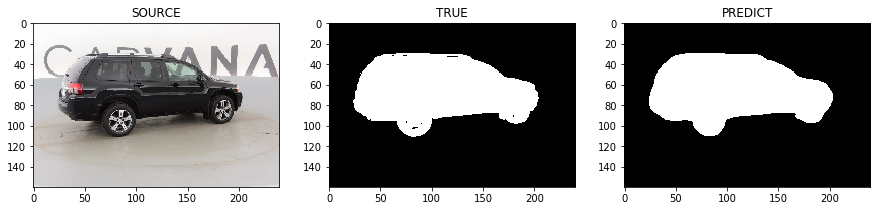

In [6]:
img = image.img_to_array(image.load_img('DATA/Stored/train/4e5ac4b9f074_12.jpg', target_size=DIM[:2]))
mask = image.img_to_array(image.load_img('DATA/Stored/train_masks/4e5ac4b9f074_12_mask.jpg', target_size=DIM[:2], color_mode = "grayscale"))
img = np.expand_dims(img, axis=0)
mask = np.expand_dims(mask, axis=0)
pred = model.predict(img)
plt.figure(figsize=(15,15))
plt.subplot(131)
plt.title('SOURCE')
plt.imshow(image.array_to_img(img[0]))
plt.subplot(132)
plt.title('TRUE')
plt.imshow(image.array_to_img(mask[0]))
plt.subplot(133)
plt.title('PREDICT')
plt.imshow(image.array_to_img(pred[0]))
plt.show()